# 1. Cài đặt và chuẩn bị môi trường

In [ ]:
!pip uninstall -y transformers
!pip uninstall -y tokenizers
!pip uninstall -y huggingface_hub

Found existing installation: transformers 4.49.0
Uninstalling transformers-4.49.0:
  Successfully uninstalled transformers-4.49.0
Found existing installation: tokenizers 0.21.1
Uninstalling tokenizers-0.21.1:
  Successfully uninstalled tokenizers-0.21.1
Found existing installation: huggingface-hub 0.30.2
Uninstalling huggingface-hub-0.30.2:
  Successfully uninstalled huggingface-hub-0.30.2


In [ ]:
!pip install transformers==4.49.0
!pip install underthesea
!pip install vncorenlp
!pip install scikit-learn
!pip install pyarrow

  Using cached transformers-4.49.0-py3-none-any.whl.metadata (44 kB)
  Using cached huggingface_hub-0.30.2-py3-none-any.whl.metadata (13 kB)
  Using cached tokenizers-0.21.1-cp39-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.8 kB)
Using cached transformers-4.49.0-py3-none-any.whl (10.0 MB)
Using cached huggingface_hub-0.30.2-py3-none-any.whl (481 kB)
Using cached tokenizers-0.21.1-cp39-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.0 MB)
  Using cached underthesea-6.8.4-py3-none-any.whl.metadata (15 kB)
  Using cached python_crfsuite-0.9.11-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.3 kB)
  Using cached underthesea_core-1.0.4-cp311-cp311-manylinux2010_x86_64.whl.metadata (1.7 kB)
Using cached underthesea-6.8.4-py3-none-any.whl (20.9 MB)
Using cached underthesea_core-1.0.4-cp311-cp311-manylinux2010_x86_64.whl (657 kB)
Using cached python_crfsuite-0.9.11-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.3 MB)
     ━━━━━━━━

# 2. Import & Load dữ liệu

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import os
import torch
from torch.utils.data import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report
from torch.nn.functional import softmax

# 3. Tiền xử lý + Dataset class

In [ ]:
# Dùng tokenizer từ PhoBERT
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base")

class HateDataset(Dataset):
    def __init__(self, texts, labels, max_len=128):
        self.texts = texts
        self.labels = labels
        self.max_len = max_len

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        encoding = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding="max_length",
            truncation=True,
            return_attention_mask=True,
            return_tensors="pt"
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(),
            "attention_mask": encoding["attention_mask"].squeeze(),
            "labels": torch.tensor(self.labels[idx], dtype=torch.long)
        }

    def __len__(self):
        return len(self.texts)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


# 4. Train phase 1: Pretrain on noisy data (VOZ-HSD)

In [ ]:
# Chia voz-hsd thành các file nhỏ 500k dòng
voz_df = pd.read_csv("/content/drive/MyDrive/ColabNotebooks/DetectComment/voz-hsd.csv", engine="pyarrow")
voz_df = voz_df.sample(frac=1, random_state=42).reset_index(drop=True)  # Shuffle cho ngẫu nhiên

chunk_size = 500_000  # Mỗi file 500k dòng
os.makedirs("/content/drive/MyDrive/ColabNotebooks/DetectComment/voz_chunks", exist_ok=True)

for i in range(0, len(voz_df), chunk_size):
    chunk = voz_df.iloc[i:i+chunk_size]
    chunk.to_csv(f"/content/drive/MyDrive/ColabNotebooks/DetectComment/voz_chunks/voz_chunk_{i//chunk_size}.csv", index=False)

print(f"Đã chia thành {len(os.listdir('/content/drive/MyDrive/ColabNotebooks/DetectComment/voz_chunks'))} file.")

In [ ]:
def freeze_phobert_encoder(model, freeze_layers=8):
    """
    Freeze các layers đầu tiên của PhoBERT.
    Ví dụ freeze_layers=8 nghĩa là freeze 8 layer đầu.
    """
    for name, param in model.named_parameters():
        if name.startswith("roberta.encoder.layer."):
            layer_num = int(name.split(".")[3])
            if layer_num < freeze_layers:
                param.requires_grad = False
    print(f"✅ Đã freeze {freeze_layers} layers đầu tiên của encoder.")

In [ ]:
# Train lần lượt từng chunk
model = AutoModelForSequenceClassification.from_pretrained("vinai/phobert-base", num_labels=2)

# Freeze encoder
freeze_phobert_encoder(model, freeze_layers=8)

training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/ColabNotebooks/DetectComment/pretrain_voz",
    per_device_train_batch_size=32,
    gradient_accumulation_steps=4,
    num_train_epochs=1,
    learning_rate=5e-5,
    save_strategy="epoch",
    logging_dir="./logs",
    save_total_limit=2,
    fp16=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=None,  # set sau
)

chunk_files = sorted(os.listdir("/content/drive/MyDrive/ColabNotebooks/DetectComment/voz_chunks"))

for idx, chunk_file in enumerate(chunk_files):
    print(f"Training on {chunk_file}")
    chunk_df = pd.read_csv(f"/content/drive/MyDrive/ColabNotebooks/DetectComment/voz_chunks/{chunk_file}")
    train_dataset = HateDataset(chunk_df["texts"], chunk_df["labels"])

    trainer.train_dataset = train_dataset

    if idx == 0:
        trainer.train(resume_from_checkpoint=False)
    else:
        trainer.train(resume_from_checkpoint=True)

    # Save model checkpoint sau mỗi chunk
    model.save_pretrained("/content/drive/MyDrive/ColabNotebooks/DetectComment/pretrain_voz")
    tokenizer.save_pretrained("/content/drive/MyDrive/ColabNotebooks/DetectComment/pretrain_voz")

print("✅ Đã pretrain xong trên toàn bộ VOZ-HSD!")


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/phobert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Đã freeze 8 layers đầu tiên của encoder.
Training on voz_chunk_0.csv


wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: vuvietanh993 (vuvietanh993-hanoi-university-of-science-and-technology) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss
500,0.127400
1000,0.096000
1500,0.087300
2000,0.082300
2500,0.076700
3000,0.076500
3500,0.074700


Training on voz_chunk_1.csv


Step,Training Loss


Training on voz_chunk_10.csv


Step,Training Loss


Training on voz_chunk_11.csv


Step,Training Loss


Training on voz_chunk_12.csv


Step,Training Loss


Training on voz_chunk_13.csv


Step,Training Loss


Training on voz_chunk_14.csv


Step,Training Loss


Training on voz_chunk_15.csv


Step,Training Loss


Training on voz_chunk_16.csv


Step,Training Loss


Training on voz_chunk_17.csv


Step,Training Loss


Training on voz_chunk_18.csv


Step,Training Loss


Training on voz_chunk_19.csv


Step,Training Loss


Training on voz_chunk_2.csv


Step,Training Loss


Training on voz_chunk_20.csv


Step,Training Loss


Training on voz_chunk_21.csv


Step,Training Loss


Training on voz_chunk_3.csv


Step,Training Loss


Training on voz_chunk_4.csv


Step,Training Loss


Training on voz_chunk_5.csv


Step,Training Loss


Training on voz_chunk_6.csv


Step,Training Loss


Training on voz_chunk_7.csv


Step,Training Loss


Training on voz_chunk_8.csv


Step,Training Loss


Training on voz_chunk_9.csv


Step,Training Loss


✅ Đã pretrain xong trên toàn bộ VOZ-HSD!


# 5. Train phase 2: Fine-tune on clean data (ViHSD)

In [ ]:
from transformers import EarlyStoppingCallback

model = AutoModelForSequenceClassification.from_pretrained("/content/drive/MyDrive/ColabNotebooks/DetectComment/pretrain_voz")
for param in model.parameters():
    param.requires_grad = True

# Load dữ liệu VIHSD đã chia sẵn
train_vihsd = pd.read_csv("/content/drive/MyDrive/ColabNotebooks/DetectComment/vihsd/train.csv")
val_vihsd = pd.read_csv("/content/drive/MyDrive/ColabNotebooks/DetectComment/vihsd/dev.csv")
test_vihsd = pd.read_csv("/content/drive/MyDrive/ColabNotebooks/DetectComment/vihsd/test.csv")

# Gộp nhãn OFFENSIVE + HATE thành 1 trong cả 3 bộ dữ liệu
for df in [train_vihsd, val_vihsd, test_vihsd]:
    df['label_id'] = df['label_id'].replace({2: 1})

train_dataset = HateDataset(train_vihsd["free_text"], train_vihsd["label_id"])
val_dataset = HateDataset(val_vihsd["free_text"], val_vihsd["label_id"])

training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/ColabNotebooks/DetectComment/finetune_vihsd",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_dir="./logs_finetune",
    learning_rate=1e-6,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    save_total_limit=1,
    fp16=True,
    greater_is_better=False,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
)

trainer.train()


Epoch,Training Loss,Validation Loss
1,0.284900,0.316795
2,0.276900,0.308936
3,0.259200,0.301732
4,0.254000,0.299306
5,0.246900,0.299299
6,0.251800,0.296685
7,0.237800,0.298500
8,0.246600,0.298984
9,0.238300,0.296695


TrainOutput(global_step=13527, training_loss=0.2570460111469002, metrics={'train_runtime': 2021.9825, 'train_samples_per_second': 118.933, 'train_steps_per_second': 7.433, 'total_flos': 1.423641298341888e+16, 'train_loss': 0.2570460111469002, 'epoch': 9.0})

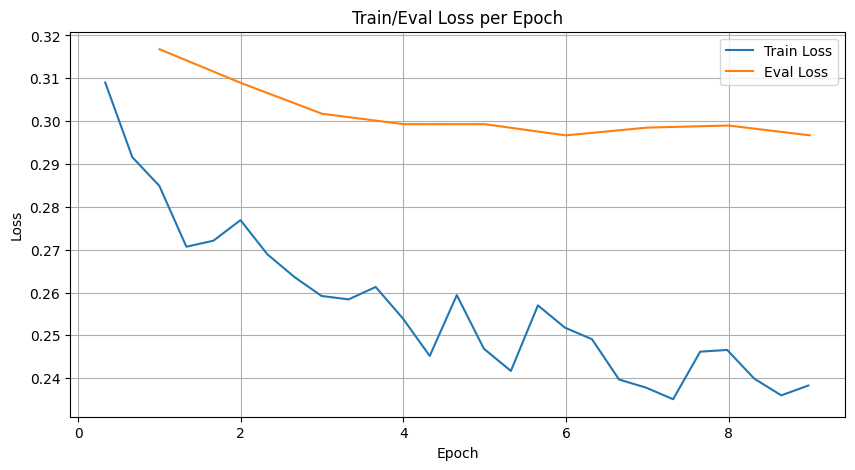

In [ ]:
# Fix the plotting code
logs = trainer.state.log_history

# Separate training and evaluation logs
train_logs = [log for log in logs if "loss" in log and "epoch" in log and "eval_loss" not in log]
eval_logs = [log for log in logs if "eval_loss" in log]

# Extract data for training plot
train_loss = [log["loss"] for log in train_logs]
train_epochs = [log["epoch"] for log in train_logs]

# Extract data for evaluation plot
eval_loss = [log["eval_loss"] for log in eval_logs]
eval_epochs = [log["epoch"] for log in eval_logs]

# Plot both curves
plt.figure(figsize=(10,5))
plt.plot(train_epochs, train_loss, label="Train Loss")
plt.plot(eval_epochs, eval_loss, label="Eval Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Train/Eval Loss per Epoch")
plt.grid(True)
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

# Tạo dataset từ tập test
test_dataset = HateDataset(test_vihsd["free_text"], test_vihsd["label_id"])

# Hiển thị số lượng mẫu
print(f"Số lượng mẫu trong tập test: {len(test_dataset)}")

# Dự đoán
predictions = trainer.predict(test_dataset)

# logits -> nhãn dự đoán
pred_labels = predictions.predictions.argmax(axis=1)

# Nhãn thật
true_labels = predictions.label_ids

# Tính accuracy
acc = accuracy_score(true_labels, pred_labels)

print(f"🎯 Accuracy trên tập test: {acc * 100:.2f}%")

# In báo cáo chi tiết
print("\n📋 Classification Report:")
print(classification_report(true_labels, pred_labels, digits=4))


Số lượng mẫu trong tập test: 6680


🎯 Accuracy trên tập test: 89.36%

📋 Classification Report:
              precision    recall  f1-score   support

           0     0.9169    0.9587    0.9374      5548
           1     0.7395    0.5742    0.6464      1132

    accuracy                         0.8936      6680
   macro avg     0.8282    0.7665    0.7919      6680
weighted avg     0.8868    0.8936    0.8881      6680



# 6. Lưu mô hình để dùng trong API

In [ ]:
model.save_pretrained("/content/drive/MyDrive/ColabNotebooks/DetectComment/hate_speech_model")
tokenizer.save_pretrained("/content/drive/MyDrive/ColabNotebooks/DetectComment/hate_speech_model")
!zip -r /content/drive/MyDrive/ColabNotebooks/DetectComment/hate_speech_model.zip /content/drive/MyDrive/ColabNotebooks/DetectComment/hate_speech_model

  adding: content/drive/MyDrive/ColabNotebooks/DetectComment/hate_speech_model/ (stored 0%)
  adding: content/drive/MyDrive/ColabNotebooks/DetectComment/hate_speech_model/config.json (deflated 49%)
  adding: content/drive/MyDrive/ColabNotebooks/DetectComment/hate_speech_model/model.safetensors (deflated 13%)
  adding: content/drive/MyDrive/ColabNotebooks/DetectComment/hate_speech_model/tokenizer_config.json (deflated 77%)
  adding: content/drive/MyDrive/ColabNotebooks/DetectComment/hate_speech_model/special_tokens_map.json (deflated 57%)
  adding: content/drive/MyDrive/ColabNotebooks/DetectComment/hate_speech_model/added_tokens.json (stored 0%)
  adding: content/drive/MyDrive/ColabNotebooks/DetectComment/hate_speech_model/vocab.txt (deflated 55%)
  adding: content/drive/MyDrive/ColabNotebooks/DetectComment/hate_speech_model/bpe.codes (deflated 59%)


# 7. Dự đoán test nhanh

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.nn.functional import softmax

# Load lại model và tokenizer đã lưu
model_path = "/content/drive/MyDrive/ColabNotebooks/DetectComment/hate_speech_model"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)
model.eval()

# Text cần dự đoán
text = "Mình rất trân trọng công sức của bạn, thật sự là vậy. Nhưng mà bài viết này thì đúng nghĩa rác rưởi chó đẻ, thậm chí còn xúc phạm trí tuệ người đọc. Mong bạn dành thời gian học lại trước khi chia sẻ ý kiến ra cộng đồng vì đó là điều rất quan trọng há."

# Tokenize
inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)

# Không cần tính toán gradient trong lúc dự đoán
with torch.no_grad():
    outputs = model(**inputs)

# Softmax để lấy xác suất
probs = softmax(outputs.logits, dim=1)
label_id = torch.argmax(probs, dim=1).item()
confidence = probs[0][label_id].item() * 100

# Mapping id -> nhãn
label_map = {0: "CLEAN", 1: "HATE"}

# In kết quả
for i, label in label_map.items():
    print(f"{label}: {probs[0][i].item() * 100:.2f}%")

print("\nKết luận dự đoán:")
print("Kết quả:", label_map[label_id])
print("Tỷ lệ dự đoán:", f"{confidence:.2f}%")



Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


CLEAN: 21.22%
HATE: 78.78%

Kết luận dự đoán:
Kết quả: HATE
Tỷ lệ dự đoán: 78.78%
